# Solutions for Lab Sheet 7 (COM3502-4502-6502 Speech Processing)

This lab sheet (solution) is part of the lecture COM[3502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level3/com3502.html "Open web page for COM3502 module")-[4502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level4/com4502.html "Open web page for COM4502 module")-[6502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/msc/com6502.html "Open web page for COM4502 module") Speech Processing at the [University of Sheffield](https://www.sheffield.ac.uk/ "Open web page of The University of Sheffield"), Dept. of [Computer Science](https://www.sheffield.ac.uk/dcs "Open web page of Department of Computer Science, University of Sheffield").

It is probably easiest to open this Jupyter Notebook with [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true "Open in Google Colab") since GitHub's Viewer does not always show all details correctly. <a href="https://colab.research.google.com/github/sap-shef/SpeechProcesssingLab/blob/main/Lab-Sheet-Solutions/Lab-Sheet-7-Solution.ipynb"><img align="right" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open Notebook in Google Colab" title="Open and Execute the Notebook directly in Google Colaboratory"></a>

Please put questions, comments and correction suggestions in the [Blackboard](https://vle.shef.ac.uk) discussion board or send an email to [s.goetze@sheffield.ac.uk](mailto:s.goetze@sheffield.ac.uk).

In [1]:
# Let's do the ususal necessary and nice-to-have imports
%matplotlib inline
import matplotlib.pyplot as plt     # plotting
import seaborn as sns; sns.set()    # styling ((un-)comment if you want)
import numpy as np                  # math

# imports we need in addition for this lab sheet
from IPython import display as ipd  # to listen to audio
import scipy.signal as sig          # for PSD calculation
import soundfile as sf              # to load WAVE files

## A Random Signal - Task 1

We will deal with random signals in the following. A random signal $n[k]$ with a [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution), a.k.a. Gaussian distribution, can be generated using `numpy`s function `np.random.normal()`. 

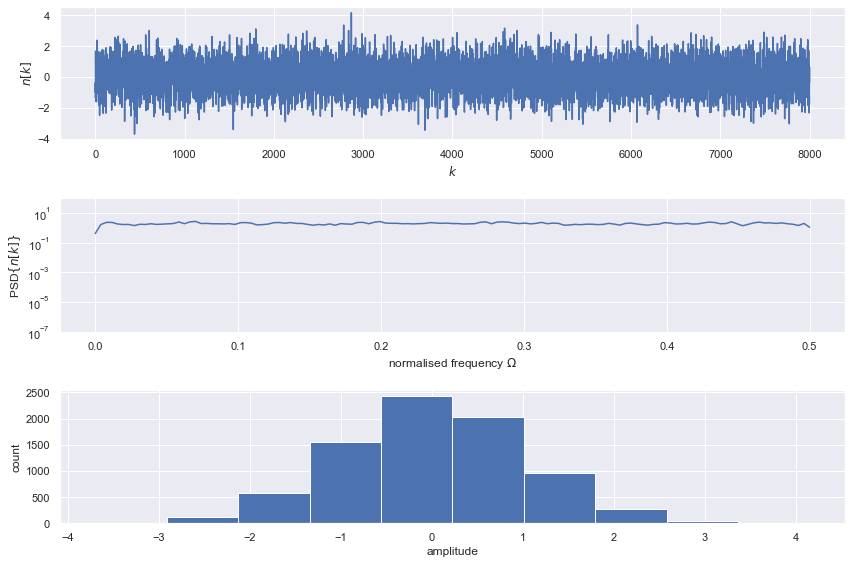

In [2]:
# create a normally distributed random signal of legth 1 second
noise=np.random.normal(size=8000)

plt.figure(figsize=(12,8))

# visualise the signal
plt.subplot(3,1,1)
plt.plot(noise)
plt.xlabel('$k$')
plt.ylabel('$n[k]$')

# show power spectral dendity
plt.subplot(3,1,2)
Omega, Pxx = sig.welch(noise)
plt.semilogy(Omega, Pxx)
plt.ylim([1e-7, 1e2])

plt.xlabel('normalised frequency $\Omega$')

plt.ylabel('PSD$\{n[k]\}$')
#plt.plot(1/len(noise)*np.abs(np.fft.fft(noise)**2))

# visualise the histogram
plt.subplot(3,1,3)
plt.hist(noise)
plt.xlabel('amplitude')
plt.ylabel('count')

plt.tight_layout()

# listen to the sound file
ipd.Audio(noise, rate=8000)

The figure above shows a noise signal in time-domain (upper panel) and in frequency domain (in terms of the [power spectral density](https://en.wikipedia.org/wiki/Spectral_density), PSD, middle panel). While we could just calculate the squared spectrum to estimate the PSD, the [Welch method](https://en.wikipedia.org/wiki/Welch%27s_method) applied here shows us a PSD with less variance. The lower panel shows the amplitude distribution of the time domain signal $n[k]$ in terms of a histogram.

From the PSD we see that the signal has a flat spectrum, i.e. it is [white noise](https://en.wikipedia.org/wiki/White_noise). The histogram reveals that the amplitude values are distributed normally. We can therefore conclude that the function `np.random.normal()` creates Gaussian white noise.

## A periodically repeated Random Signal - Task 2

To add some *structure* to the signal we will generate a periodic random signal of length $L = 8000$ samples in the following by concatenating $L/P$ repetitions of a random signal of length $P=100$ samples. 

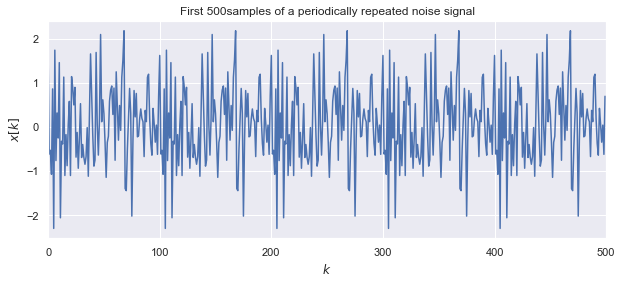

In [3]:
L = 8000 # total length of signal
P = 100  # period

K = 250  # upper/lower limit for lag in ACF

# generate periodic random signal
np.random.seed(1) # this ensures that always the same "random" signal is generated
x0 = np.random.normal(size=P)
x  = np.tile(x0, L//P)

plt.figure(figsize=(10, 4))
#plt.stem(x[:2*K], basefmt='C0:', use_line_collection=True)
plt.plot(x[:2*K])
plt.xlim(0, 2*K)
plt.xlabel('$k$')
plt.ylabel('$x[k]$')
plt.title('First '+str(2*K)+'samples of a periodically repeated noise signal')
plt.grid(True)

# listen to the sound file
ipd.Audio(x, rate=8000)

The structure in the signal (each $P=100$ samples) is visible in the plot above.

## Autocorrelation Sequence, a.k.a. Autocorrelation Function

In a [previous notebook (Lab-Sheet 3)](./Lab-Sheet-3-Solution.ipynb) we calculated the [correlation](https://en.wikipedia.org/wiki/Correlation_and_dependence) and the correlation coefficient $\hat{r}_{xx}$ as a scalar quantity indicating how correlated two signals (of the same length) are. Correlation in general is a statistical measure for the dependencies between random processes or between the samples of one random process. As a result we are interested in the (auto-)correlation between $x[k]$ and $x[k-\kappa]$, the time-shifted version of $x[k]$. This information can be analysed by the [auto-correlation function](https://en.wikipedia.org/wiki/Autocorrelation) (ACF) which characterizes the temporal dependencies within one random signal $x[k]$. We will use the ACF for estimation of the fundamental (pitch) frequency of a speech excitation signal in the later part of this notebook.

### Background Theory and Definition

For a continuous-amplitude, real-valued random signal $x[k]$ the ACF is defined by expectation $\mathrm{E}\{ \cdot  \}$ of the signal at two different time-instants $k_1$ and $k_2$

\begin{equation}
r_{xx}[k_1, k_2] = \mathrm{E}\{ x[k_1] \cdot x[k_2] \}. \tag{1}
\label{eq:AutocorrelationDesinition}
\end{equation}

If we assume [wide-sense stationarity](stationary_ergodic.ipynb#Wide-Sense-Stationary-Random-Processes) (WSS) the ACF does only depend on the time difference $\kappa = k_1 - k_2$ between the considered sample indices and we can simplify (\ref{eq:AutocorrelationDesinition}) to

\begin{equation}
r_{xx}[\kappa] = \mathrm{E}\{x[k] \cdot x[k-\kappa] \}, \tag{2}
\label{eq:AutocorrelationDesinitionStationary}
\end{equation}

where $\kappa$ is commonly chosen as sample index instead of $k$ to indicate that it denotes a time shift / lag. The ACF quantifies the similarity of a signal with a shifted version of itself. It has high (positive / negative) values for high similarity and low (positive / negative) values for low similarity which is in line with our findings from [Lab-Sheet 3](./Lab-Sheet-3-Solution.ipynb).


### A Correlation Estimator

Since the definitions in (\ref{eq:AutocorrelationDesinition}) and (\ref{eq:AutocorrelationDesinitionStationary}) depend on the expectation operator $\mathrm{E}\{ \cdot \}$, which can only be estimated rather than calculated, we are interested in such an estimator for $r_{xx}[\kappa]$. Thus, we define the *autocorrelation function estimate* at a time shift $\kappa$ of the signal $x[k]$ of length $L$ as

\begin{equation}
\hat{r}_{xx}[\kappa] = \frac{1}{L} \sum_{k=1}^{L-1}x[k]x[k+\kappa]  \tag{3}
\label{eq:AutocorrelationEstFullSum}
\end{equation}

for all values of $\kappa$ from $0$ to $L-1$, i.e., for each $\kappa$ we correlate the non-shifted signal with a signal shifted by $\kappa$ samples. Note that the hat $\hat\cdot$ indicates that $\hat{r}_{xx}[\kappa]$ is the estimate of $r_{xx}[\kappa]$.

Note that in numerical implementations (e.g. MATLAB, Python with `mode='full'`), the computed ACF returns a vector of length $2 L - 1$ containing values from negative $\kappa$s to positive $\kappa$s. For an interpretation with respect to the actual time lag $\kappa$, $L-1$ must be subtracted from these indices. More previsely, the autocorrelation is symmetric regarding $\kappa=0$ for real-valued signals.

Further note that $\frac{1}{L}$-averaging in (\ref{eq:AutocorrelationEstFullSum}) yields a [biased estimator](https://en.wikipedia.org/wiki/Bias_of_an_estimator) of the ACF, which consistently should be denoted with $\hat{r}_{xx,\mathrm{biased}}[\kappa]$. The bias is in form of a triangle and which can be removed by adapting the normalisation. The unbiased estimator of the ACF is given as
$$\hat{r}_{xx,\mathrm{unbiased}}[\kappa] = \frac{1}{L-|\kappa|}\sum_{k=0}^{L-1} x[k] \cdot x[k-\kappa].$$

The following code will visualise the ACF estimate according to (\ref{eq:AutocorrelationEstFullSum}).

Length of the signal x is L=8000
Length of the ACF is : 15999
[ 1.41730637e-04 -1.79265134e-04  1.01781303e-05 ...  1.01781303e-05
 -1.79265134e-04  1.41730637e-04]


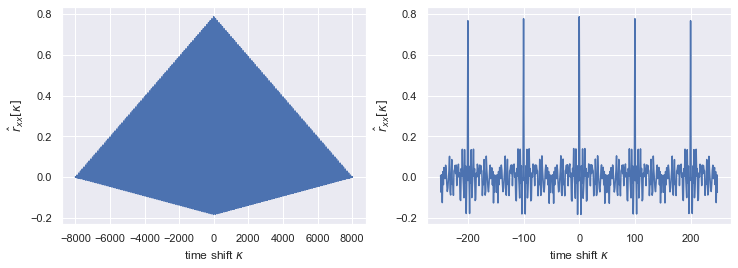

In [4]:
K = 250  # upper/lower limit for lag in ACF

# compute the ACF
acf = 1/len(x) * np.correlate(x, x, mode='full')


print('Length of the signal x is L=' + str(len(x)))
print('Length of the ACF is : ' + str(len(acf)))
print(acf)

# plot ACF over full length
kappa = np.arange(-(L-1), L)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(kappa,acf)
plt.xlabel('time shift $\kappa$')
plt.ylabel('$\hat{r}_{xx}[\kappa]$')

# truncate ACF and plot area of interest around the center
acf_center=(len(x)-1)
kappa = np.arange(-(L-1), L)
plt.subplot(1,2,2)
plt.plot(kappa[acf_center-(K-1):acf_center+(K-1)],
         acf[acf_center-(K-1):acf_center+(K-1)])
plt.xlabel('time shift $\kappa$')
plt.ylabel('$\hat{r}_{xx}[\kappa]$')
None # suppress last output

The two panels in the figure above both show the same function, i.e. the ACF. The plot in the right panel is of limited use since the fine structure of the ACF is not visible. However, it showes the bias of the estimate in form of a tiangular general shaping. The right panel shows the ACF zommed into the area of interest i.e for $K \leq \kappa \leq K$ with $K=250$.

The prpminent peak in the cetre (at $\kappa=0$) indicated that the signal is highly correlated with itself if it is not shifted (which is true for all possible signals). More interesting are the other peaks which have a distance of $100$ samples each. This means that the signal has high similarity with itself for each shift of $100$ samples (which is how we designed our periodic noise signal).

The following code reproduced the ACF $\hat{r}_{xx}[\kappa]$ in larger scale and with the cutout of the original signal $x[k]$ to visualise that the periodicity is much easier to determin in the ACF $\hat{r}_{xx}[\kappa]$ than in the time domain signal $x[k]$.

-249 <= kappa <= 249


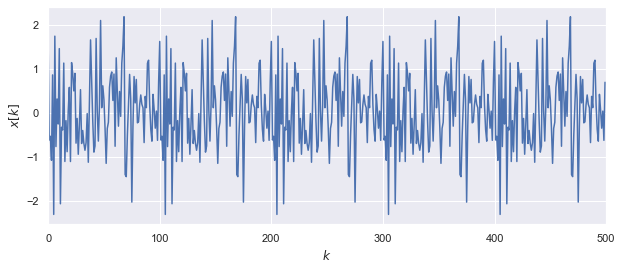

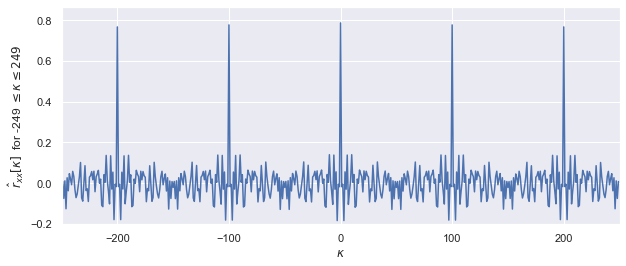

In [5]:
# compute and truncate ACF
acf = 1/len(x) * np.correlate(x, x, mode='full')
acf = acf[(len(x)-1)-(K-1):(len(x)-1)+K]
kappa = np.arange(-(K-1), K)
print(str(np.min(kappa)) + ' <= kappa <= ' + str(np.max(kappa)) )

# plot signal and its ACF
plt.figure(figsize=(10, 4))
#plt.stem(x[:2*K], basefmt='C0:', use_line_collection=True)
plt.plot(x[:2*K])
plt.xlim(0, 2*K)
plt.xlabel('$k$')
plt.ylabel('$x[k]$')
plt.grid(True)

plt.figure(figsize=(10, 4))
#plt.stem(kappa, acf, basefmt='C0:', use_line_collection=True)
plt.plot(kappa, acf)
plt.xlabel('$\kappa$')
plt.ylabel('$\hat{r}_{xx}[\kappa]$  for ' + str(np.min(kappa)) + ' $\leq \kappa \leq ' + str(np.max(kappa)) + '$')
plt.axis([-K, K, 1.1*min(acf), 1.1*max(acf)])
plt.grid(True)

# Autocorrelation of Voices Sound Segment - Task 4

Since we analysed that the ACF analyses periodicity in a signal and also the period of this periodicity we use the ACF in the following to determine the periodicity within a speech signal segment $s[k]$. The following code loads a speech signal segment $s[k]$ from the Internet and into a Python variable `s`. 

In [6]:
# download speech and noise example files
s_file_name = 'voiced_unvoiced_e.wav'
!curl https://staffwww.dcs.shef.ac.uk/people/S.Goetze/sound/{s_file_name} -o {s_file_name} 

# load speech wave into variable
s, fs = sf.read(s_file_name)

print('File "' + s_file_name + '" loaded. Its sampling rate is ' + str(fs) + ' Hz.')

# listen to the sound file (if you want)
ipd.Audio(s, rate=fs)

File "voiced_unvoiced_e.wav" loaded. Its sampling rate is 44100 Hz.


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 77100  100 77100    0     0   364k      0 --:--:-- --:--:-- --:--:--  365k


We visualise the beginning of the speech sound signal $s[k]$ which is a sustained vovel  in the following. We see the beginning of a periodic segment. The lower panel of the following plot calculate the ACF $\hat{r}_{ss}[\kappa]$.

-999 <= kappa <= 999


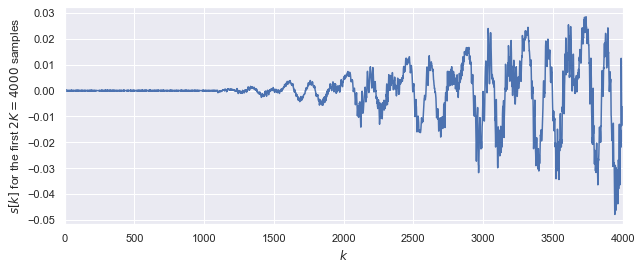

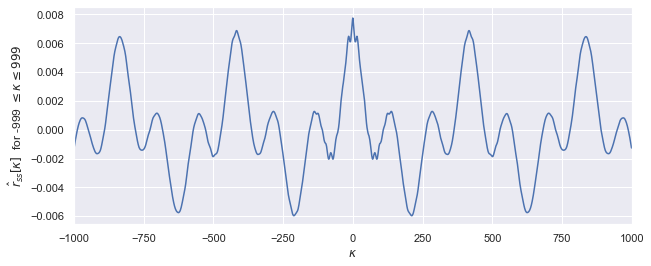

In [8]:
K=1000

# compute and truncate ACF
acf = 1/len(s) * np.correlate(s, s, mode='full')
acf = acf[(len(s)-1)-(K-1):(len(s)-1)+K]
kappa = np.arange(-(K-1), K)
print(str(np.min(kappa)) + ' <= kappa <= ' + str(np.max(kappa)) )

# plot signal and its ACF
plt.figure(figsize=(10, 4))
#plt.stem(x[:4*K], basefmt='C0:', use_line_collection=True)
plt.plot(s[:4*K])
plt.xlim(0, 4*K)
plt.xlabel('$k$')
plt.ylabel('$s[k]$ for the first $2K='+str(4*K)+'$ samples')
plt.grid(True)

plt.figure(figsize=(10, 4))
#plt.stem(kappa, acf, basefmt='C0:', use_line_collection=True)
plt.plot(kappa, acf)
plt.xlabel('$\kappa$')
plt.ylabel('$\hat{r}_{ss}[\kappa]$  for ' + str(np.min(kappa)) + ' $\leq \kappa \leq ' + str(np.max(kappa)) + '$')
plt.axis([-K, K, 1.1*min(acf), 1.1*max(acf)])
plt.grid(True)

## Fundamental Frequency Estimation

With the knowledge of the ACF we will now extract the fundamental frequency $f_0$ of a speech signal which is a.k.a. pitch frequency and is the frequency exitation of the speech production system, i.e. after the [vocal cords](https://en.wikipedia.org/wiki/Vocal_cords).

To determine $f_0$ we first calculate the autocorrelation estimate $\hat{r}_{xx}[\kappa]$ of the signal and then look for the highest correlation value. To determine the periodicity of the signal we are interested in the distance of the ACF maxima. Since we know that we always have a maximum at $\kappa=0$ we are interested in identifying the second main maximum.

To be more robust in case of mixed (voiced/unvoiced) excitation  signals, we only look in the time shift range which corresponds to likely frequencies for human voice. Typical pitch frequencies for humans are in an range between $f_{min}=50$ Hz and $f_{max}=500$ Hz. With the knowledge that discrete time variables $\kappa$ are related to discrete frequency variables by the sampling frequency $f_s$ we can calculate the *search area* (orange shaded below) between $\kappa_{\mathrm{max}} = \operatorname{round}\left(\frac{f_s}{f_{\mathrm{max}}}\right)$ and $\kappa_{\mathrm{min}} = \operatorname{round}\left(\frac{f_s}{f_{\mathrm{min}}}\right)$.

Between those two values we find the time-shift $\kappa_0$ of the maximal value which gives us the corresponding frequency $f_0 = \frac{f_s}{\kappa_0}$.

The relation is also shown in the following figure where we see some autocorrelation sequence and observe how $f_{min}$ and $f_{max}$ constrain the search space for the highest autocorrelation value.

<img src="autocorrelation_frequencies.svg" align="center"/>

Note that the absolute numbers in the figure above are only valid if the sampling frequency $f_s$ matches. The formulas, however, are generally applicable.

Length of ACF:    1999
ACF center index: 999
kappa_min:        1087
kappa_max:        1881
maximum at 1416, i.e. 417 from $\kappa=0.$.
pitch frequency $f_0$ is 105.75539568345324 Hz


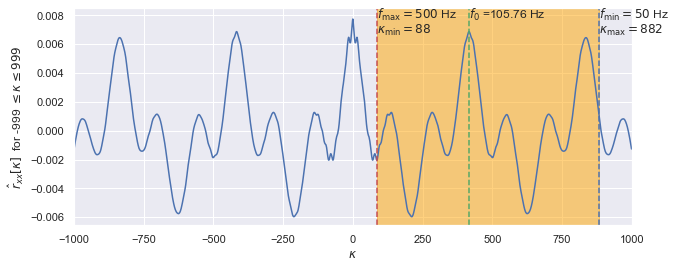

In [9]:
f_min_hz=50    # lower frequency in Hz defining our search range
f_max_hz=500   # upper frequency in Hz defining our search range

# The minimal and maximal shift (in samples) we want to look at is calculated from the frequency boundaries
kappa_acf_center=len(acf)//2
kappa_min = kappa_acf_center + int(np.round(fs / f_max_hz))
kappa_max = kappa_acf_center + int(np.round(fs / f_min_hz))

print('Length of ACF:    '+str(len(acf)))
print('ACF center index: '+str(kappa_acf_center))
print('kappa_min:        '+str(kappa_min))
print('kappa_max:        '+str(kappa_max))

# find the maximum value of the ACF (in the search range)
max_correlation_kappa = kappa_min + np.argmax(acf[kappa_min : kappa_max + 1])

# calculate pitch frequency
f_p=fs/(max_correlation_kappa-kappa_acf_center)

print('maximum at '+str(max_correlation_kappa)+', i.e. '+
      str(max_correlation_kappa-kappa_acf_center)+' from $\kappa=0.$.')
print('pitch frequency $f_0$ is '+str(f_p)+' Hz')


plt.figure(figsize=(10, 4))
#plt.stem(kappa, acf, basefmt='C0:', use_line_collection=True)
plt.plot(kappa, acf)
plt.xlabel('$\kappa$')
plt.ylabel('$\hat{r}_{xx}[\kappa]$  for ' + str(np.min(kappa)) + ' $\leq \kappa \leq ' + str(np.max(kappa)) + '$')
plt.axis([-K, K, 1.1*min(acf), 1.1*max(acf)])

# add a shaded area illustrating the "search range"
plt.axvspan(kappa_min-kappa_acf_center,kappa_max-kappa_acf_center, alpha=0.5, color='orange')

# add vertical lines to the plot to visualise found values
plt.axvline(kappa_min-kappa_acf_center, color='r', ls='--')
plt.axvline(kappa_max-kappa_acf_center, color='b', ls='--')
plt.axvline(max_correlation_kappa-kappa_acf_center, color='g', ls='--')

# add some annotation
plt.text(kappa_min-kappa_acf_center,np.max(acf),
         '$f_{\mathrm{max}}='+str(f_max_hz)+'$ Hz')
plt.text(kappa_max-kappa_acf_center,np.max(acf),
         '$f_{\mathrm{min}}='+str(f_min_hz)+'$ Hz')
plt.text(kappa_min-kappa_acf_center,np.max(acf)-0.001,
         '$\kappa_{\mathrm{min}}='+str(kappa_min-kappa_acf_center)+'$')
plt.text(kappa_max-kappa_acf_center,np.max(acf)-0.001,
         '$\kappa_{\mathrm{max}}='+str(kappa_max-kappa_acf_center)+'$')
plt.text(max_correlation_kappa-kappa_acf_center,np.max(acf),
         '$f_0$ =%.2f Hz' % f_p)
plt.grid(True)

## Copyright

This notebook is licensed to be used during the lecture COM[3502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level3/com3502.html "Open web page for COM3502 module")-[4502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level4/com4502.html "Open web page for COM4502 module")-[6502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/msc/com6502.html "Open web page for COM4502 module") Speech Processing at the [University of Sheffield](https://www.sheffield.ac.uk/ "Open web page of The University of Sheffield"), Dept. of [Computer Science](https://www.sheffield.ac.uk/dcs "Open web page of Department of Computer Science, University of Sheffield"). Any further use (beyond use for the lecture) is only permitted if agreed with the [module lead](mailto:s.goetze@sheffield.ac.uk). 

### Contributors
[Stefan Goetze](http://www.stefan-goetze.de "Web page of Stefan Goetze"),
[Lena Strobl](https://github.com/sleyna/)